### Analyze list of compounds


In [21]:
import math
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import *
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['pdf.fonttype'] = 42  # make font editable in pdf
plt.rcParams['font.family'] = 'Verdana'
init_notebook_mode(connected=True)  # initiate notebook for offline plot

Option to set all plots to presentation mode

In [22]:
# sns.set_context("talk")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 1})
def save_fig(file_name):
    plt.savefig("figures/{}.png".format(file_name), dpi=300)
    plt.savefig("figures/{}.pdf".format(file_name))
    plt.savefig("figures/{}.svg".format(file_name))
    # plt.savefig("results/{}.eps".format(file_name))

### Load data and create list of data columns
The data table is loaded from the results folder. _value_columns_ holds all numeric columns. _class_columns_ might be
 interesting to group data.

In [23]:
df = pd.read_csv("results/MCE_Library_zdenek_converted.tsv", sep="\t")
# df = pd.read_csv("results/full_table.tsv", sep="\t")
df["md_by_mass"] = df.apply(lambda row: row["mass_defect"]/row["exact_mass"]*100, axis=1)

value_columns = ("exact_mass	mass_defect	md_by_mass	mol_log_p	valenz	hba	hbd	num_rot_bonds	hetero_atoms	c_atoms	o_atoms	heavy_atoms").split("\t")

class_columns = ("class_results_np_classifier	superclass_results_np_classifier	pathway_results_np_classifier	isglycoside_np_classifier	fp1_np_classifier	fp2_np_classifier	kingdom_classyfire	superclass_classyfire	class_classyfire	subclass_classyfire	intermediate_nodes_classyfire	alternative_parents_classyfire	direct_parent_classyfire	molecular_framework_classyfire	substituents_classyfire	description_classyfire	external_descriptors_classyfire	ancestors_classyfire	predicted_chebi_terms_classyfire	predicted_lipidmaps_terms_classyfire	classification_version_classyfire	therapeutic_flag_chembl	natural_product_chembl	indication_class_chembl	num_chembl_entries	chirality_chembl	max_phase_chembl").split("\t")

other_columns = ("molecule_chembl_id_chembl	pref_name_chembl	molecule_synonyms_chembl	wikipedia_id_chembl	pubchem_id_chembl").split("\t")

no_distribution_columns = ("aromatic_rings	n_atoms	p_atoms	s_atoms	halogen_atoms	alogp_chembl	cx_logd_chembl	cx_logp_chembl	cx_most_apka_chembl	cx_most_bpka_chembl").split("\t")

### Tabular summary

In [41]:
total_rows = len(df)
summary = [("Total rows", total_rows),
    ("Glykoside (NP classifier)", len([1 for x in df.isglycoside_np_classifier if x == True])),
           ("Min mass", min([x for x in df.exact_mass if str(x).strip()])),
           ("Max mass", max([x for x in df.exact_mass if str(x).strip()])),
           ("Min C", min([x for x in df.c_atoms if str(x).strip()])),
           ("Max C", max([x for x in df.c_atoms if str(x).strip()])),
           ("chembl ID", sum([1 for x in df.num_chembl_entries if x>0])),
           ("Therapeutic flag chembl", len([1 for x in df.therapeutic_flag_chembl if x==True])),
           ("Natural product flag chembl", len([1 for x in df.natural_product_chembl if x==1])),
           ("Approved drug chembl", len([1 for x in df.max_phase_chembl if x==4])),
           ("At least stage one drug chembl", len([1 for x in df.max_phase_chembl if x>=1])),
           ("N containing", len([1 for x in df.n_atoms if x>0])),
           ("O containing", len([1 for x in df.o_atoms if x>0])),
           ("Heavy atoms containing", len([1 for x in df.heavy_atoms if x>0])),
           ("Hetero atoms containing", len([1 for x in df.hetero_atoms if x>0])),
           ("NP classifier", len([1 for x in df.class_results_np_classifier if str(x).strip()])),
           ("Antiviral", len([1 for x in df.indication_class_chembl if "antiviral" in str(x).strip().lower()])),
           ]

summary_df = pd.DataFrame(summary, columns=["Description", "Value"])
summary_df["Relative"] = summary_df["Value"].apply(lambda x: round(x/total_rows*100,1))
summary_df

Description        Value  Relative
0                       Total rows  10002.00000     100.0
1        Glykoside (NP classifier)    456.00000       4.6
2                         Min mass     45.02146       0.5
3                         Max mass   2313.13729      23.1
4                            Min C      0.00000       0.0
5                            Max C    123.00000       1.2
6                        chembl ID   7819.00000      78.2
7          Therapeutic flag chembl   1701.00000      17.0
8      Natural product flag chembl    569.00000       5.7
9             Approved drug chembl   1486.00000      14.9
10  At least stage one drug chembl   2711.00000      27.1
11                    N containing   7906.00000      79.0
12                    O containing   9337.00000      93.4
13          Heavy atoms containing  10002.00000     100.0
14         Hetero atoms containing   9983.00000      99.8
15                   NP classifier  10002.00000     100.0
16                      Anti viral     41.00000       0.4

In [58]:
indication_dict = dict()

sum_indications = ["antineoplastic", "vitamin", "antiviral", "antihypertensive", 'antihistaminic', "antidiabetic",
                   "antidepressant", "antifungal", "anticonvulsant", "anticholinergic", "antibacterial",
                   "anti-inflammatory", "anti-infective", "anti-asthmatic", "anti-adrenergic", "anesthetic",
                   "analgesic"]

for x in df.indication_class_chembl[df.indication_class_chembl.notnull()]:
    # sum indications with similar names
    for sum_indi in sum_indications:
        if sum_indi in str(x).lower():
            indication_dict[sum_indi] = indication_dict.get(sum_indi, 0) + 1

    split = str(x).split(';')
    for indication in split:
        stripped_key = indication.strip().lower()
        # exclude already captured indications
        if stripped_key not in sum_indications:
            counter = indication_dict.get(stripped_key, 0)
            indication_dict[stripped_key] = counter + 1

indication_df = pd.DataFrame(indication_dict.items(), columns=["ChEMBL_indication", "Compounds"])
indication_df.sort_values(by=["Compounds"], ascending=False, inplace=True)
indication_df

ChEMBL_indication  Compounds
16                           antibacterial        126
47                          antineoplastic         76
3                         antihypertensive         59
53                       anti-inflammatory         58
44                               antiviral         41
..                                     ...        ...
189                      steroid (topical)          1
190                      relaxant (muscle)          1
191  anti-infective, topical,antibacterial          1
195       antimalarial,deterrent (smoking)          1
336           analgesic,ultraviolet screen          1

[337 rows x 2 columns]

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


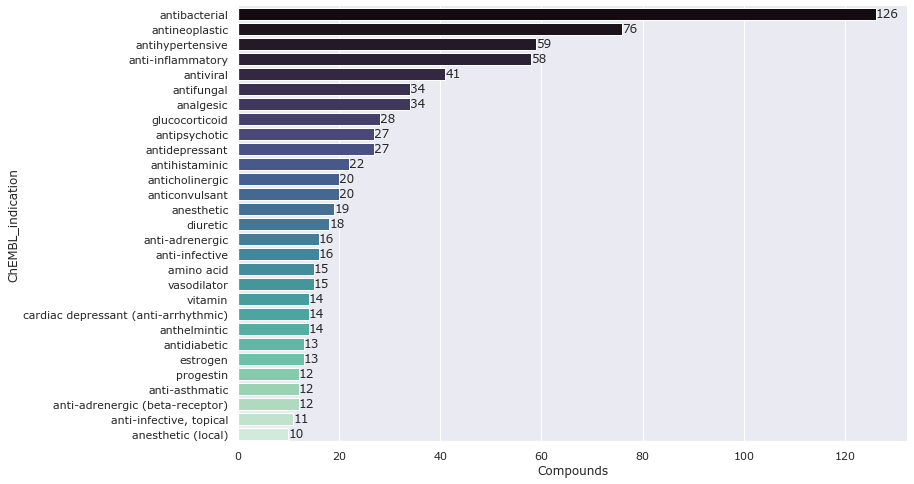

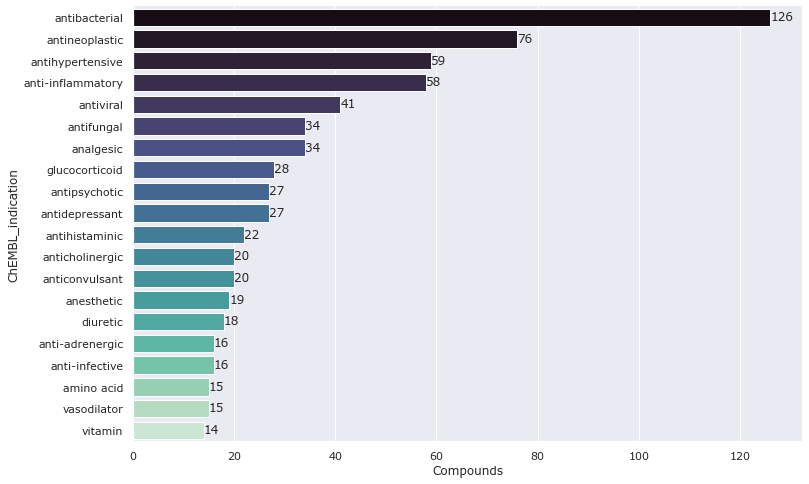

In [66]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(x="Compounds", y="ChEMBL_indication", data=indication_df[indication_df["Compounds"]>=10],
                 palette="mako")
ax.bar_label(ax.containers[0])
sns.despine()
save_fig("indication")

plt.figure(figsize=(12, 8))
ax = sns.barplot(x="Compounds", y="ChEMBL_indication", data=indication_df.head(20),
                 palette="mako")
ax.bar_label(ax.containers[0])
sns.despine()
save_fig("indication_top20")

### NP classifier results

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


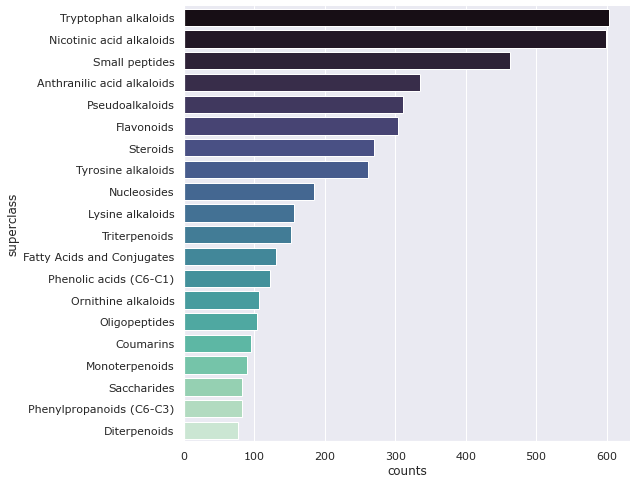

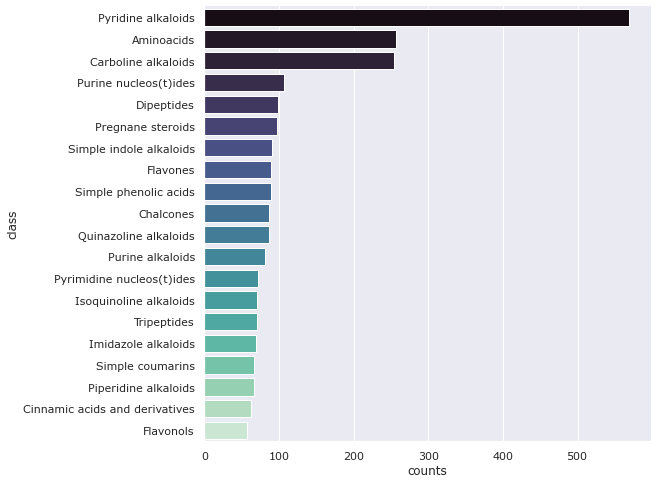

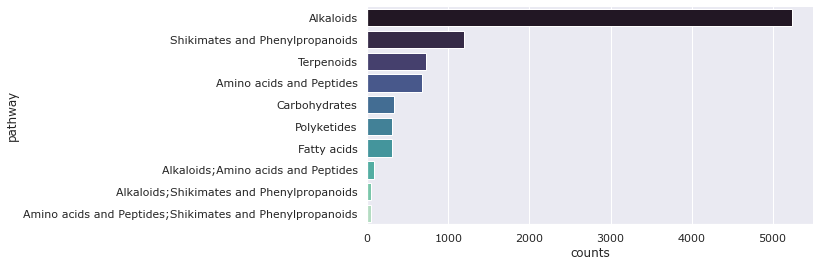

In [25]:
# count classes, create data frame, take top 20 entries
classes = df['class_results_np_classifier'].value_counts().rename_axis("class").reset_index(name="counts").head(20)
superclass = df['superclass_results_np_classifier'].value_counts().rename_axis("superclass").reset_index(name="counts").head\
    (20)
pathway = df['pathway_results_np_classifier'].value_counts().rename_axis("pathway").reset_index(name="counts").head(10)
# classes = classes.loc[classes['counts'] > 10]  # select over value
colors = sns.color_palette("crest", as_cmap=True)

plt.figure(figsize=(8, 8))
sns.barplot(x="counts", y="superclass", data=superclass, palette="mako")
sns.despine()
save_fig("np_superclass")

plt.figure(figsize=(8, 8))
sns.barplot(x="counts", y="class", data=classes, palette="mako")
sns.despine()
save_fig("np_class")

plt.figure(figsize=(8, 4))
sns.barplot(x="counts", y="pathway", data=pathway, palette="mako")
sns.despine()
save_fig("np_pathway")

### Classyfire results

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


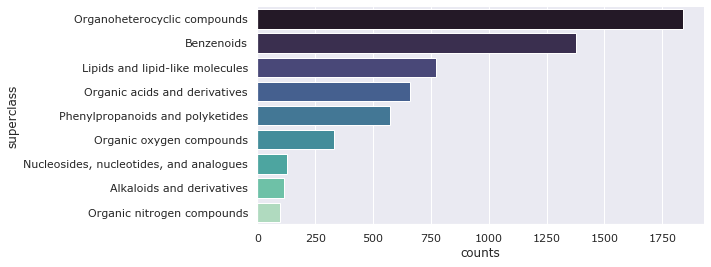

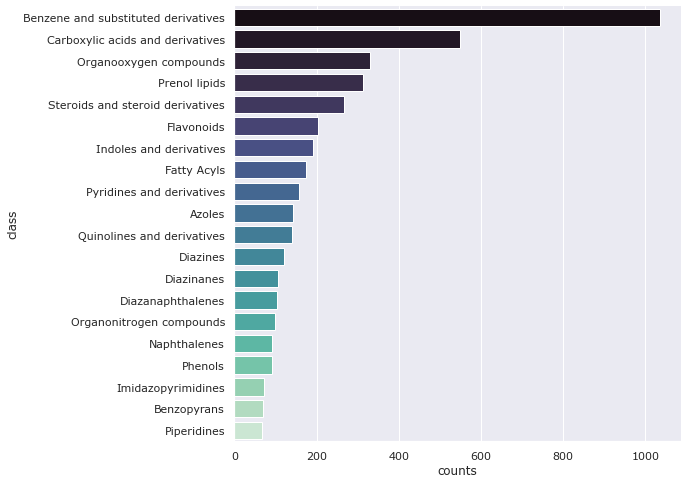

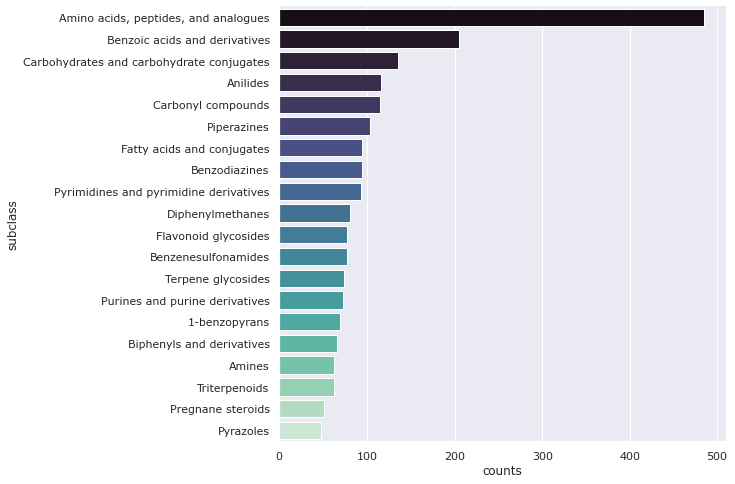

In [26]:
superclass = df['superclass_classyfire'].value_counts().rename_axis("superclass").reset_index(name="counts").head(9)
plt.figure(figsize=(8, 4))
sns.barplot(x="counts", y="superclass", data=superclass, palette="mako")
sns.despine()
save_fig("classyfire_superclass")

classes = df['class_classyfire'].value_counts().rename_axis("class").reset_index(name="counts").head(20)
plt.figure(figsize=(8, 8))
sns.barplot(x="counts", y="class", data=classes, palette="mako")
sns.despine()
save_fig("classyfire_classes")

subclass = df['subclass_classyfire'].value_counts().rename_axis("subclass").reset_index(name="counts").head(20)
plt.figure(figsize=(8, 8))
sns.barplot(x="counts", y="subclass", data=subclass, palette="mako")
sns.despine()
save_fig("classyfire_subclass")


meta NOT subset; don't know how to subset; dropped


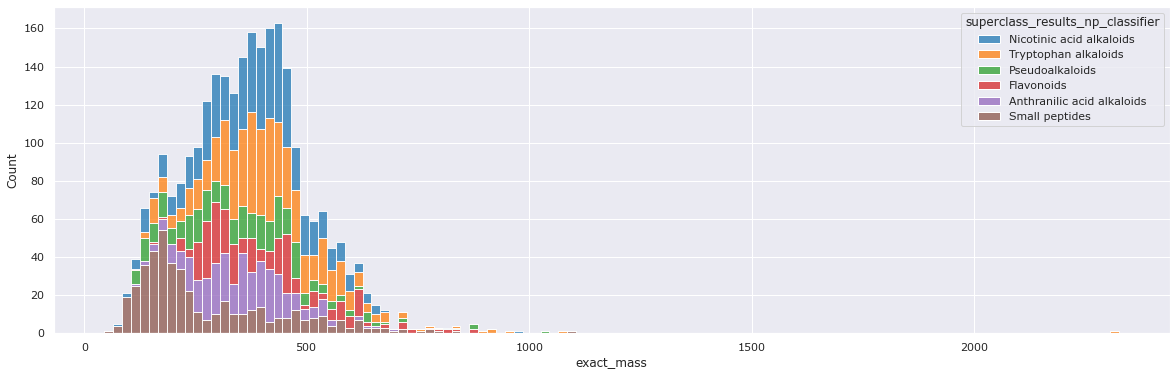

In [27]:
# take top n of np superclass
np_superclass = df['superclass_results_np_classifier'].value_counts().rename_axis("superclass").reset_index\
    (name="counts").head(6)

filtered_df = df.loc[df["superclass_results_np_classifier"].isin(np_superclass["superclass"])]

plt.figure(figsize=(20, 6))
# sns.violinplot(y="superclass_results_np_classifier", x="exact_mass", data=filtered_df)
sns.histplot(data=filtered_df, x="exact_mass", binwidth=20, hue="superclass_results_np_classifier",
                 multiple="stack")
save_fig("histo_np_superclass_top6_mass")

meta NOT subset; don't know how to subset; dropped


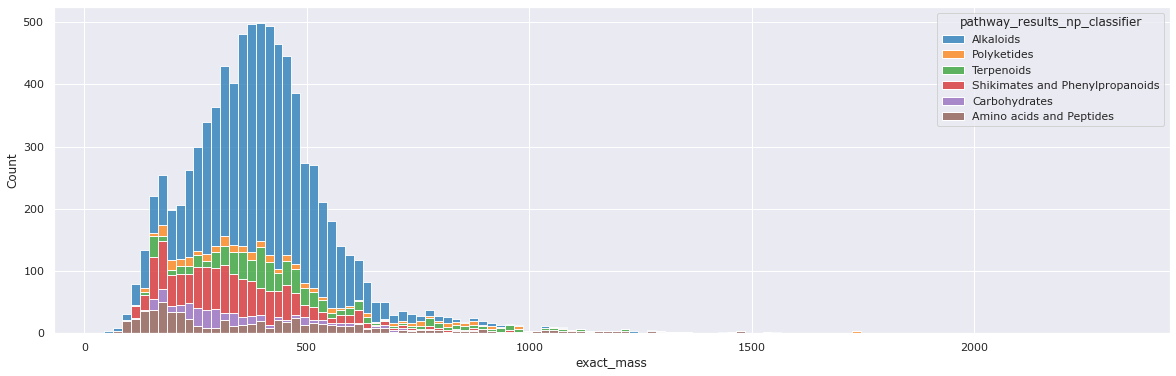

In [28]:
# take top n of np superclass
np_superclass = df['pathway_results_np_classifier'].value_counts().rename_axis("pathway").reset_index\
    (name="counts").head(6)

filtered_df = df.loc[df["pathway_results_np_classifier"].isin(np_superclass["pathway"])]

plt.figure(figsize=(20, 6))
sns.histplot(data=filtered_df, x="exact_mass", binwidth=20, hue="pathway_results_np_classifier",
                 multiple="stack")
save_fig("histo_np_pathways_top6_mass")

meta NOT subset; don't know how to subset; dropped


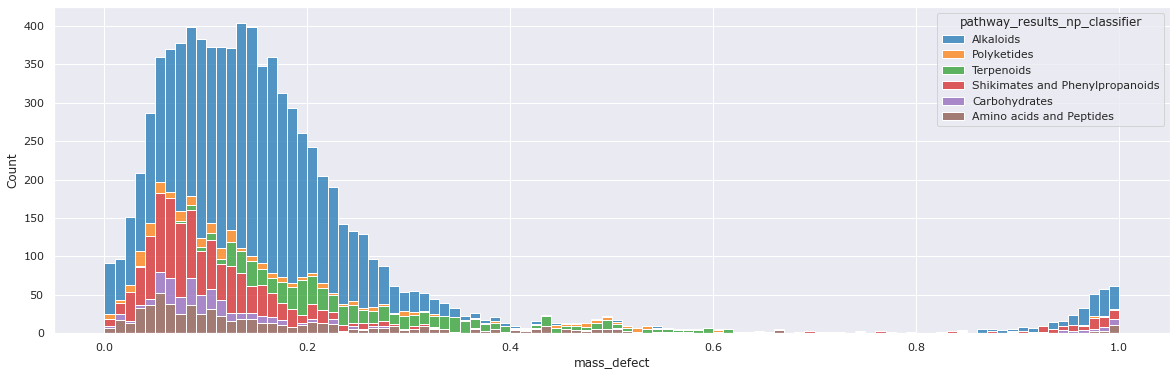

In [29]:
# take top n of np superclass
np_superclass = df['pathway_results_np_classifier'].value_counts().rename_axis("pathway").reset_index\
    (name="counts").head(6)

filtered_df = df.loc[df["pathway_results_np_classifier"].isin(np_superclass["pathway"])]

plt.figure(figsize=(20, 6))
sns.histplot(data=filtered_df, x="mass_defect", binwidth=0.01, hue="pathway_results_np_classifier",
                 multiple="stack")
save_fig("histo_np_pathways_top6_md")

In [30]:


# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(filtered_df, row="superclass_results_np_classifier",
                  hue="superclass_results_np_classifier",
                  aspect=15, height=10, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "exact_mass",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "exact_mass", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(exact_mass, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "exact_mass")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

D:\git\compound_metadata_kraken\venv\lib\site-packages\seaborn\distributions.py:316: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

D:\git\compound_metadata_kraken\venv\lib\site-packages\seaborn\distributions.py:316: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

D:\git\compound_metadata_kraken\venv\lib\site-packages\seaborn\distributions.py:316: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

D:\git\compound_metadata_kraken\venv\lib\site-packages\seaborn\distributions.py:316: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

D:\git\compound_metadata_kraken\venv\lib\site-packages\seaborn\distributions.py:316: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable 

### 2D distribution

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


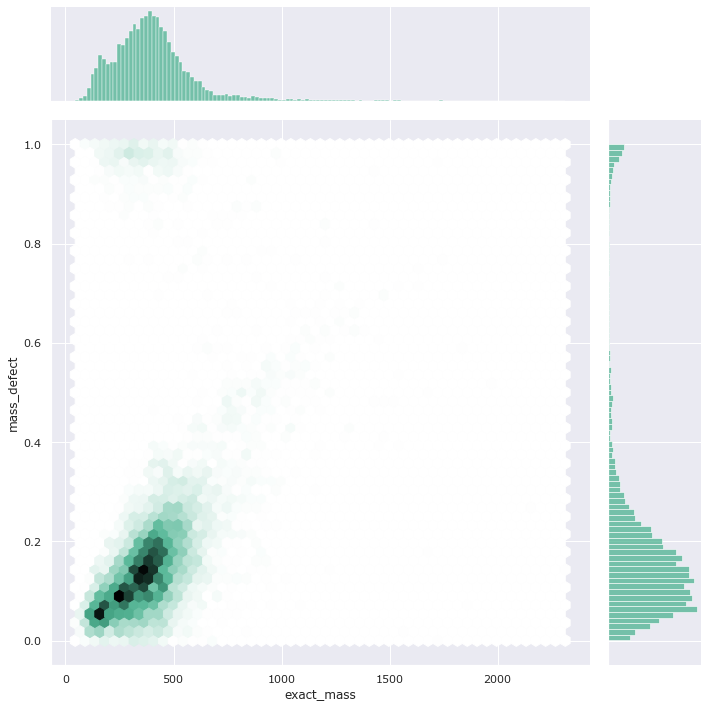

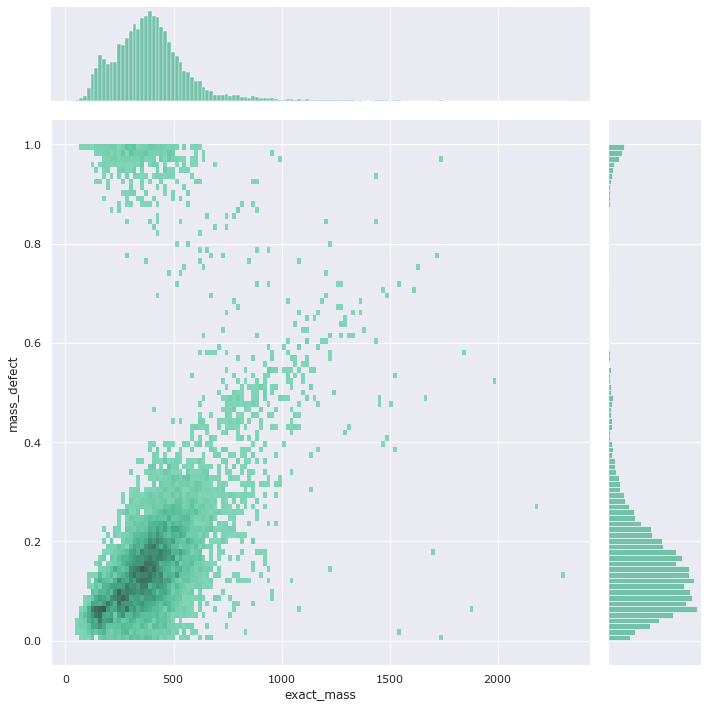

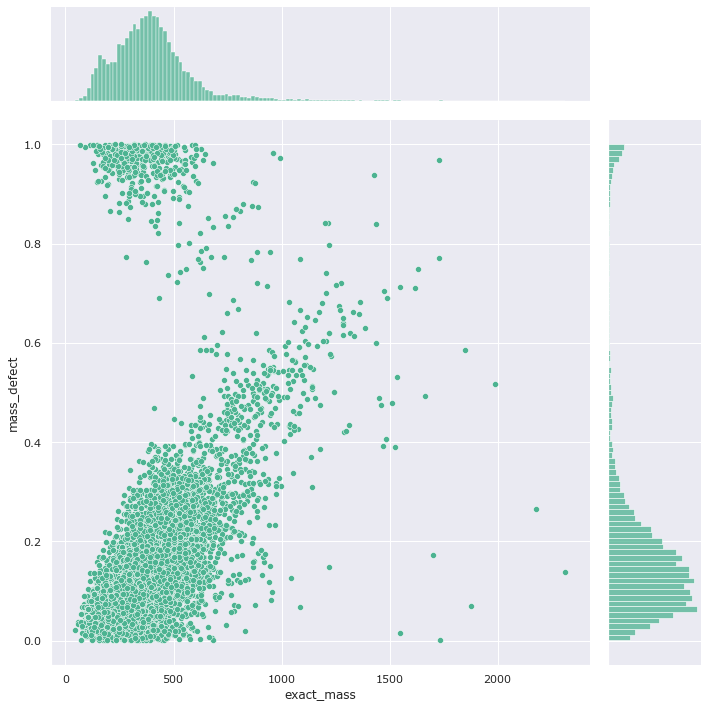

In [31]:
sns.jointplot(data=df, x="exact_mass", y="mass_defect", kind="hex", color="#4CB391", height=10)
save_fig("joint_mass_md")
sns.jointplot(data=df, x="exact_mass", y="mass_defect", kind="hist", color="#4CB391", height=10)
save_fig("joint_mass_md_b")
sns.jointplot(data=df, x="exact_mass", y="mass_defect", color="#4CB391", height=10)
save_fig("joint_mass_md_c")

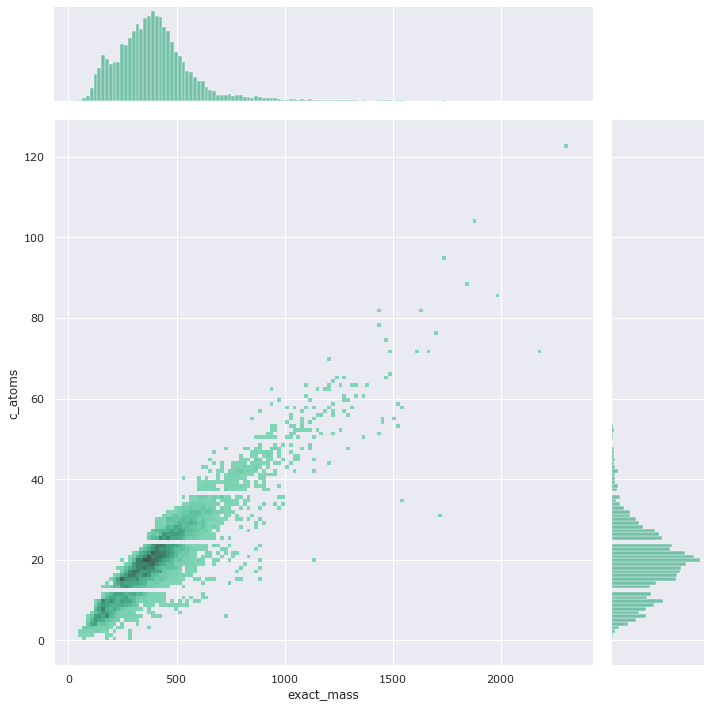

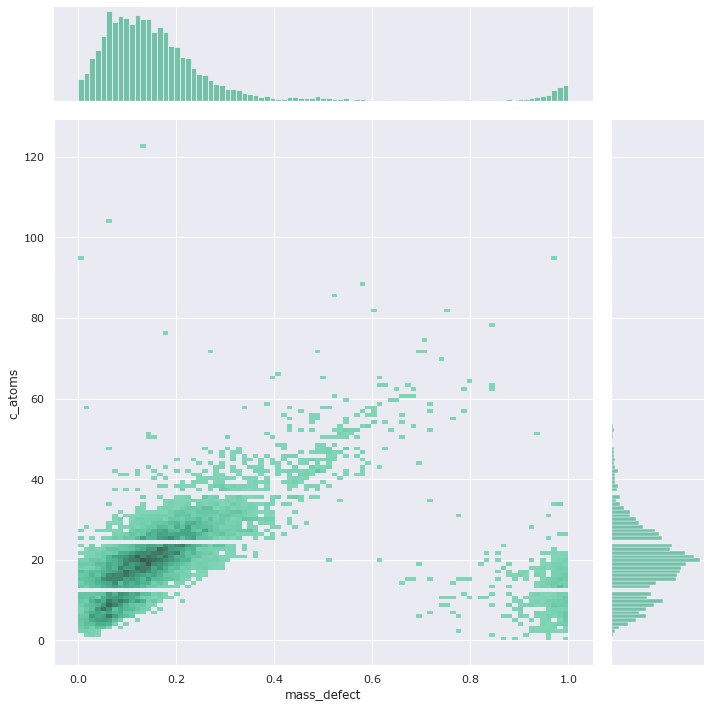

In [32]:
sns.jointplot(data=df, x="exact_mass", y="c_atoms", kind="hist", color="#4CB391",height=10)
sns.jointplot(data=df, x="mass_defect", y="c_atoms", kind="hist", color="#4CB391",height=10)

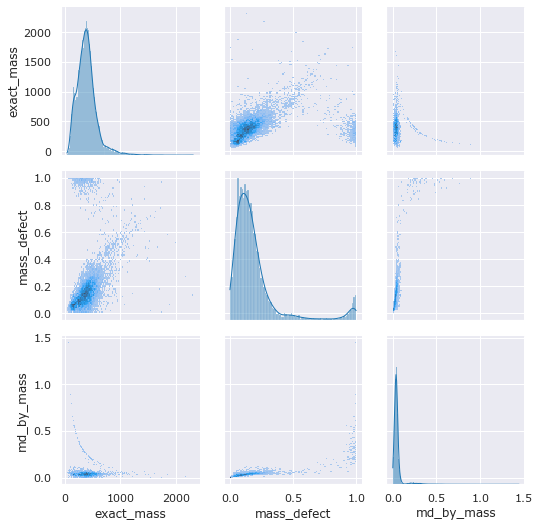

In [33]:

# num_rot_bonds, hetero_atoms
g = sns.PairGrid(df, vars=["exact_mass","mass_defect","md_by_mass"])
g.map_upper(sns.histplot)
g.map_lower(sns.histplot)
g.map_diag(sns.histplot, kde=True)

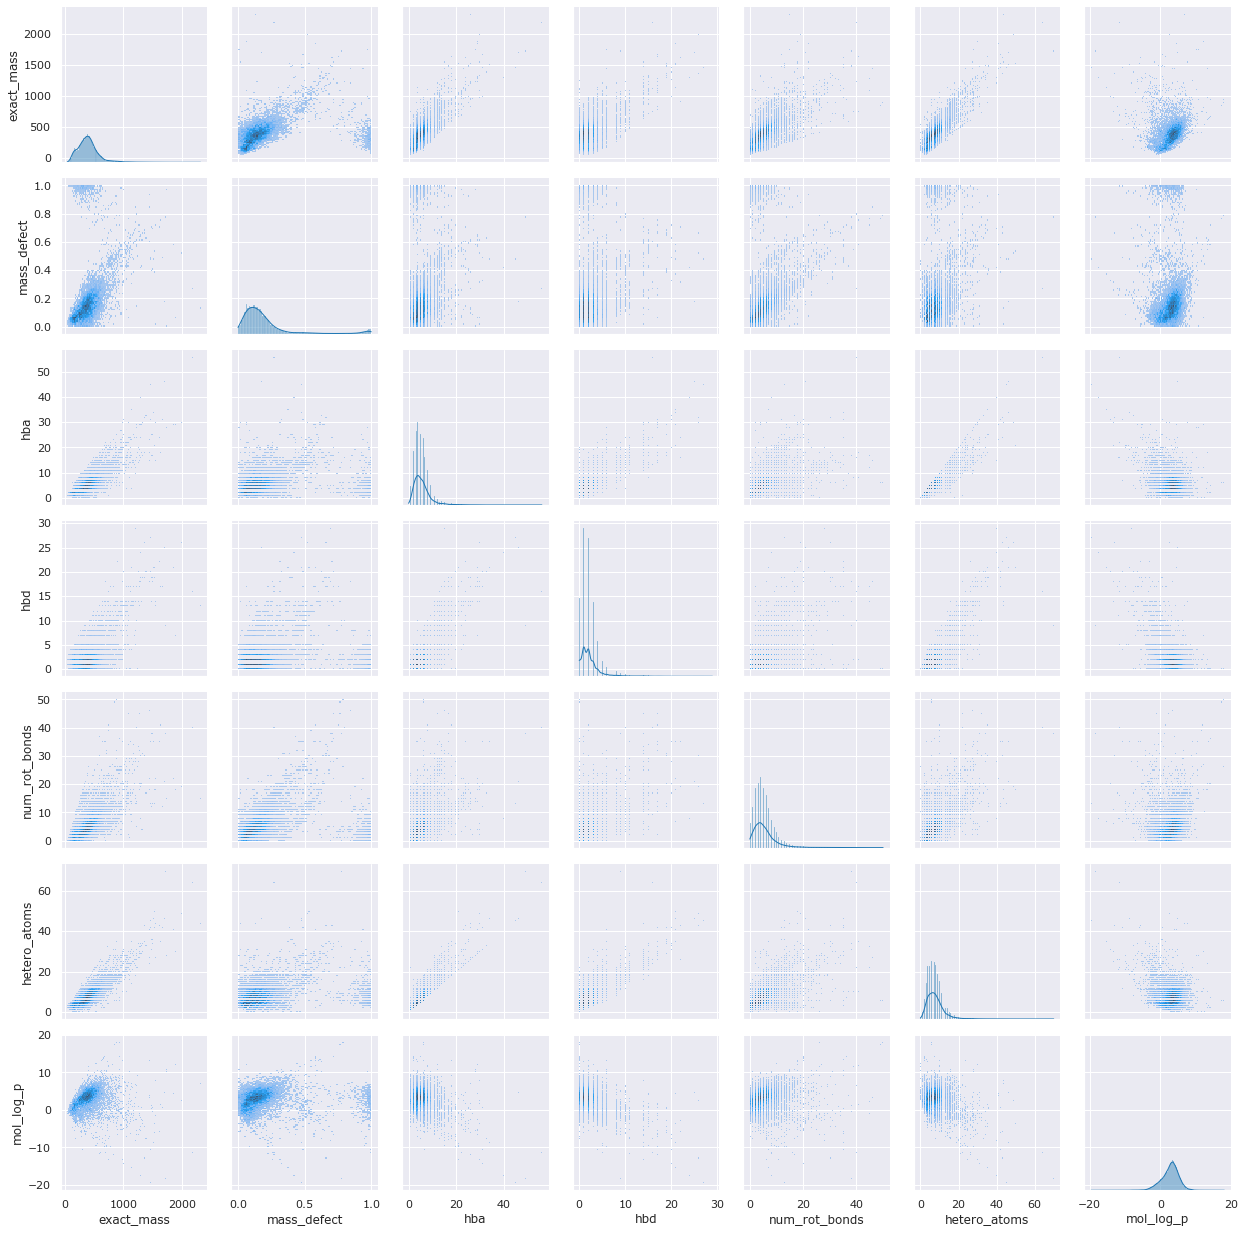

In [34]:
# num_rot_bonds, hetero_atoms mol_log_p	valenz	hba	hbd	num_rot_bonds	hetero_atoms	c_atoms	o_atoms	heavy_atoms
g = sns.PairGrid(df, vars=["exact_mass","mass_defect","hba", "hbd", "num_rot_bonds", "hetero_atoms", "mol_log_p"])
g.map_upper(sns.histplot)
g.map_lower(sns.histplot)
g.map_diag(sns.histplot, kde=True)

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


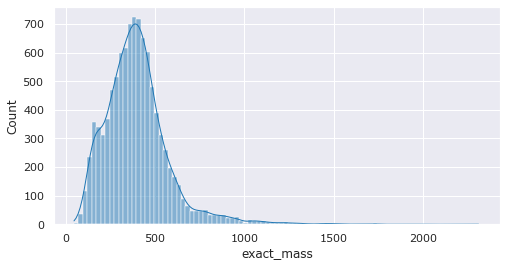

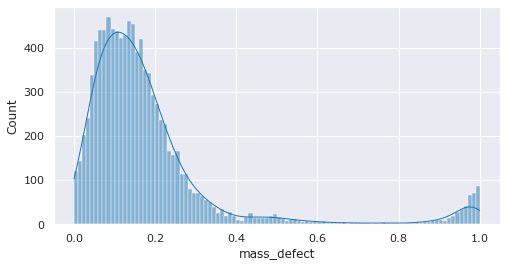

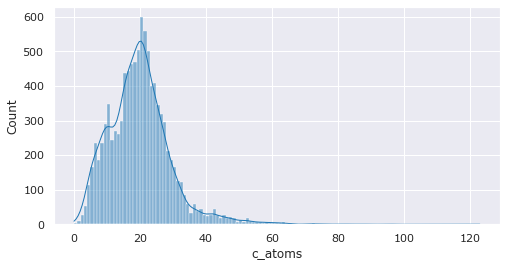

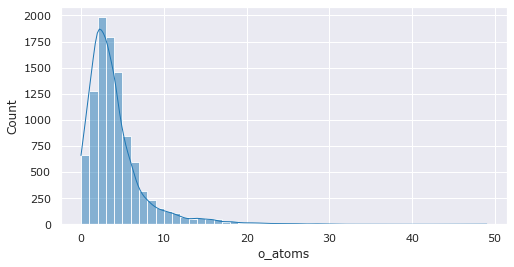

In [35]:
plt.figure(figsize=(8, 4))
sns.histplot(data=df, x="exact_mass", binwidth=25, kde=True)
save_fig("histo_exact_mass")

plt.figure(figsize=(8, 4))
sns.histplot(data=df, x="mass_defect", binwidth=0.01, kde=True)
save_fig("histo_mass_defect")

plt.figure(figsize=(8, 4))
sns.histplot(data=df, x="c_atoms", binwidth=1, kde=True)
save_fig("histo_c_atoms")

plt.figure(figsize=(8, 4))
sns.histplot(data=df, x="o_atoms", binwidth=1, kde=True)
save_fig("histo_o_atoms")

### Plot specific data as grid

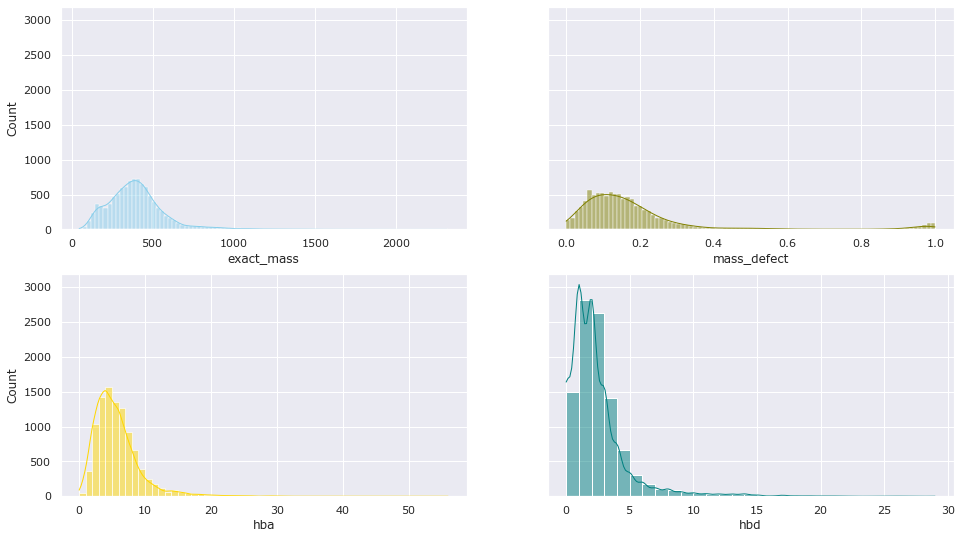

<Figure size 432x288 with 0 Axes>

In [36]:
fig, axs = plt.subplots(2, 2, sharey=True, figsize=(16, 9))

sns.histplot(data=df, x="exact_mass", binwidth=25, kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=df, x="mass_defect", kde=True, color="olive", ax=axs[0, 1])
# hba and hbd are int values with discrete intevals - therefore set bins to avoid gaps
sns.histplot(data=df, x="hba", binwidth=1, kde=True, color="gold", ax=axs[1, 0])
sns.histplot(data=df, x="hbd", binwidth=1, kde=True, color="teal", ax=axs[1, 1])

plt.show()
save_fig("hist_multi")

### Histogram grid of all value columns

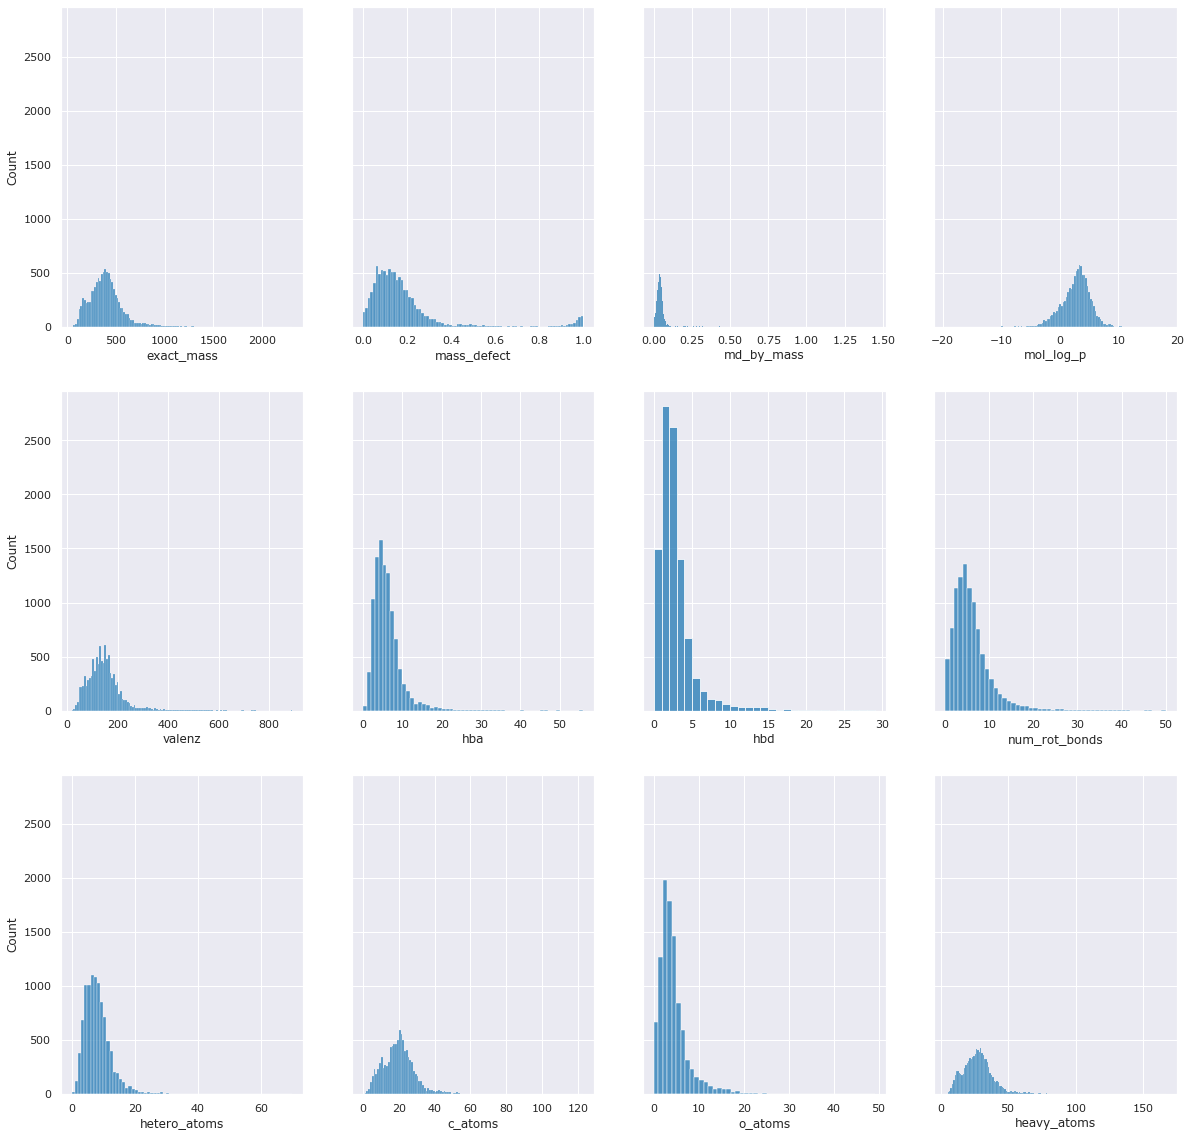

<Figure size 432x288 with 0 Axes>

In [37]:
# create grid
cols = 4
rows = math.ceil(len(value_columns)/cols)
fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(20, 20))

discrete_values_start_index = 5

for index, column in enumerate(value_columns):
    ci = index % cols
    ri = math.floor(index / cols)
    if index >= discrete_values_start_index:
        sns.histplot(data=df, binwidth=1, x=column, ax=axs[ri, ci])
    else:
        sns.histplot(data=df, x=column, ax=axs[ri, ci])

plt.show()
save_fig("histo_multi")
